In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as signal
import os
from scipy.fftpack import fft,ifft
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import glob

In [17]:
def generate_segments_from_wav(path, window=1.0):
    """
    根據 wav 檔自動讀取長度，切成每段 window 秒的區段

    Args:
        path (str): wav 路徑
        window (float): 每段幾秒（預設 1.0 秒）

    Returns:
        list: [[start, end], ...] 的 segment_table
    """
    sample_rate, sig = wavfile.read(path)
    if sig.ndim > 1:
        sig = sig.mean(axis=1)
    duration = len(sig) / sample_rate

    segments = []
    start = 0.0
    while start < duration:
        end = min(start + window, duration)
        segments.append([start, end])
        start = end
    return segments


In [18]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.io import wavfile


def get_audio(path):
    sample_rate, sig = wavfile.read(path)
    if sig.ndim > 1:
        sig = sig.mean(axis=1)  # 轉單聲道
    time = len(sig) / sample_rate
    return sample_rate, sig, time


def FFT_filter(path, segment_table, bandpass=None):
    """
    FFT 分析與 IFFT 還原，支援頻域遮罩（bandpass）

    Args:
        path (str): 音檔路徑
        segment_table (list): [[start, end], ...] 秒為單位
        bandpass (tuple or None): (low_freq, high_freq) 頻率遮罩區間，單位 Hz
    """
    sample_rate, sig, time = get_audio(path)

    Yf_list = []
    Xf_list = []
    X_list = []
    Y_list = []

    for start, end in segment_table:

        if end > time:
            print(f"⚠️ 區段 {start}-{end} 超出音檔長度 {time:.2f}s，已修正 end 為 {time:.2f}s")
            end = time

        if start >= end:
            print(f"⚠️ 無效區段：start={start}, end={end}，已跳過")
            continue

        start_idx = int(start * sample_rate)
        end_idx = int(end * sample_rate)
        segment = sig[start_idx:end_idx]

        N = len(segment)
        Yf = fft(segment) / sample_rate
        freqs = np.fft.fftfreq(N, d=1/sample_rate)

        # === 頻率遮罩 ===
        if bandpass is not None:
            low, high = bandpass
            mask = (np.abs(freqs) >= low) & (np.abs(freqs) <= high)
            Yf_filtered = np.zeros_like(Yf, dtype=complex)
            Yf_filtered[mask] = Yf[mask]
        else:
            Yf_filtered = Yf

        # 頻譜圖只取正頻率部分
        freqs_pos = freqs[:N//2]
        Yf_pos = np.abs(Yf[:N//2])

        # IFFT 還原
        y_rec = ifft(Yf_filtered).real
        x_rec = np.linspace(0, end - start, N)

        Xf_list.append(freqs_pos)
        Yf_list.append(Yf_pos)
        X_list.append(x_rec)
        Y_list.append(y_rec)

        print(f"✅ 處理 segment: {start:.2f} → {end:.2f} 秒, 長度：{end - start:.2f} 秒")

    return Xf_list, Yf_list, X_list, Y_list



✅ 處理 segment: 0.00 → 1.00 秒, 長度：1.00 秒
✅ 處理 segment: 1.00 → 2.00 秒, 長度：1.00 秒
✅ 處理 segment: 2.00 → 3.00 秒, 長度：1.00 秒
✅ 處理 segment: 3.00 → 4.00 秒, 長度：1.00 秒
✅ 處理 segment: 4.00 → 5.00 秒, 長度：1.00 秒


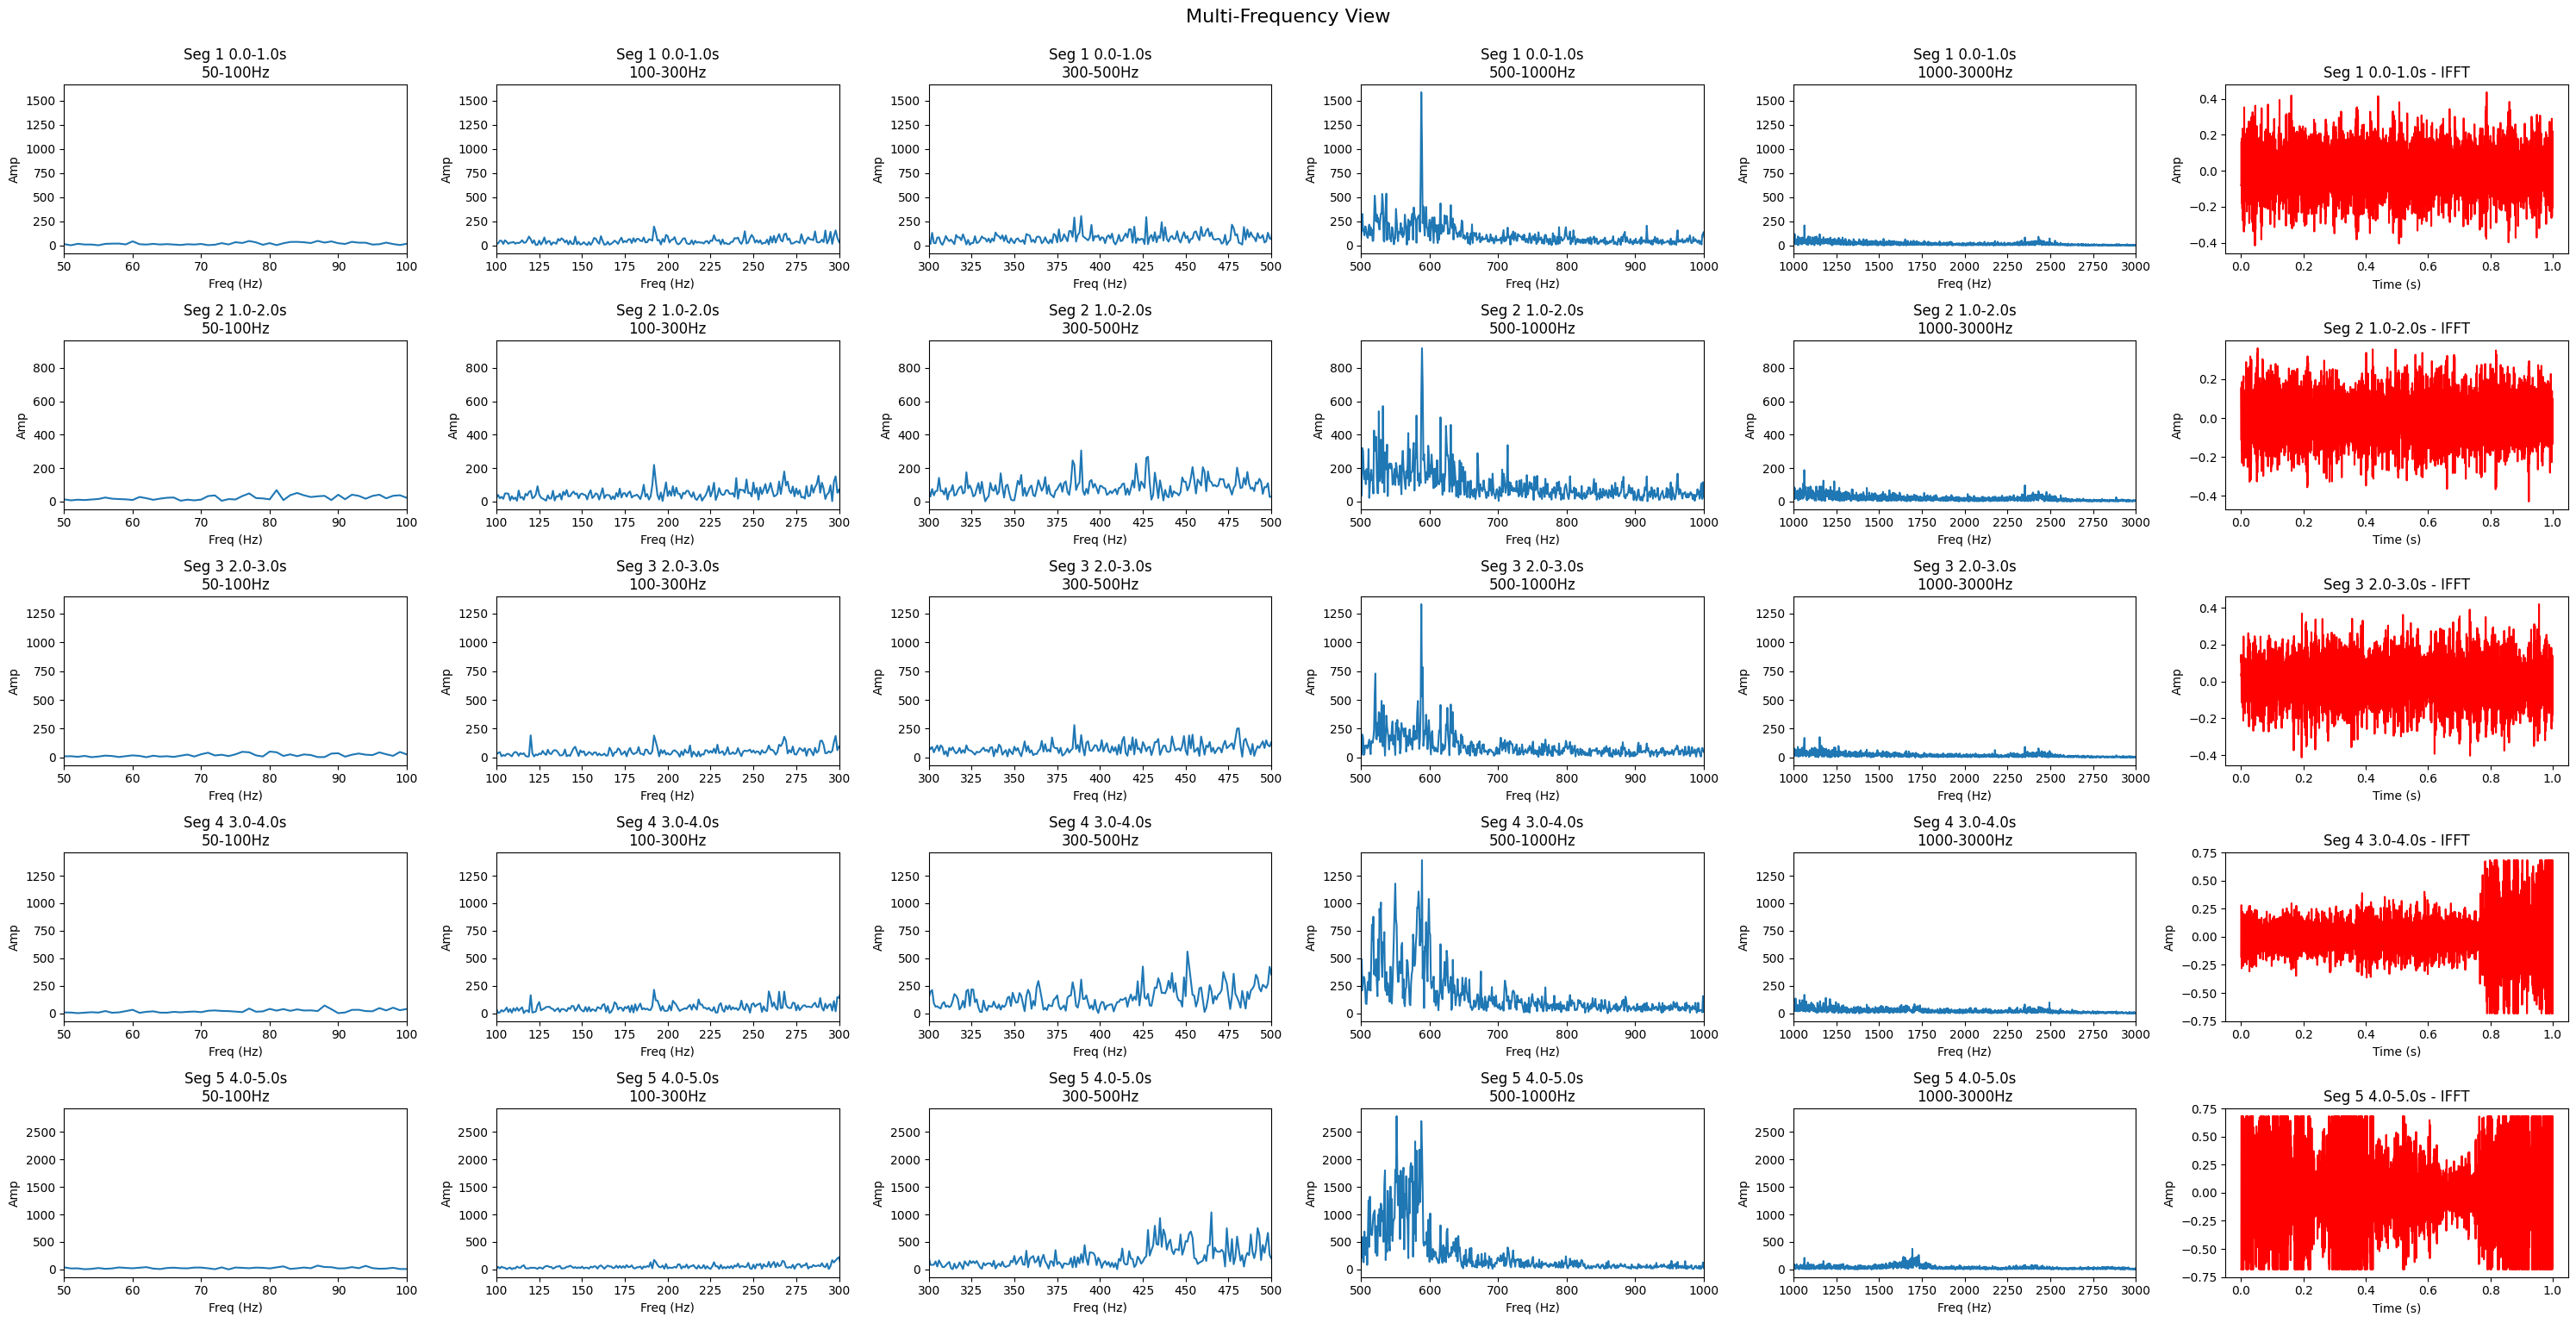

In [19]:
import matplotlib.pyplot as plt

def plot_single_audio_with_multiple_freq_ranges(
    file_path,
    freq_ranges=[(0, 500), (500, 1000), (1000, 3000)],
    window=1.0,
    title="Multi-Frequency View"
):
    segment_table = generate_segments_from_wav(file_path, window=window)
    xf, yf, x, y = FFT_filter(file_path, segment_table, bandpass=None)

    n_segments = len(x)
    n_freq_views = len(freq_ranges)

    fig, axes = plt.subplots(n_segments, n_freq_views + 1, figsize=(5 * (n_freq_views + 1), 3 * n_segments))

    if n_segments == 1:
        axes = [axes]  # 確保一維情況也能 for loop

    for i in range(n_segments):
        seg_start, seg_end = segment_table[i]
        for j, (f_start, f_end) in enumerate(freq_ranges):
            ax = axes[i][j] if n_segments > 1 else axes[j]
            ax.plot(xf[i], yf[i])
            ax.set_xlim(f_start, f_end)
            ax.set_title(f"Seg {i+1} {seg_start:.1f}-{seg_end:.1f}s\n{f_start}-{f_end}Hz")
            ax.set_xlabel("Freq (Hz)")
            ax.set_ylabel("Amp")

        # 時域圖（放在最後一欄）
        ax = axes[i][-1] if n_segments > 1 else axes[-1]
        ax.plot(x[i], y[i], color="red")
        ax.set_title(f"Seg {i+1} {seg_start:.1f}-{seg_end:.1f}s - IFFT")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amp")

    plt.tight_layout()
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.show()




plot_single_audio_with_multiple_freq_ranges(
    "validate_data/2024-10-29/leak/ITRI0000003_rate_70_2023-09-14T152746.wav",
    freq_ranges=[(50, 100), (100, 300), (300, 500), (500, 1000), (1000, 3000)],
    window=1.0
)


In [20]:
def plot_bandpassed_time_series_subplots(path, freq_ranges):
    sample_rate, sig, time = get_audio(path)
    N = len(sig)
    t = np.linspace(0, time, N)

    # 建立頻譜與頻率座標
    Yf = fft(sig) / sample_rate
    freqs = np.fft.fftfreq(N, d=1/sample_rate)

    fig, axs = plt.subplots(len(freq_ranges) + 1, 1, figsize=(14, 2.5 * (len(freq_ranges) + 1)), sharex=True)

    # ➤ 原始波形
    axs[0].plot(t, sig, color='gray', label="Original")
    axs[0].set_title("Original Signal")
    axs[0].set_ylabel("Amplitude")
    axs[0].legend()

    # ➤ 各頻段 bandpassed 波形
    for i, (low, high) in enumerate(freq_ranges):
        mask = (np.abs(freqs) >= low) & (np.abs(freqs) <= high)
        Yf_masked = np.zeros_like(Yf, dtype=complex)
        Yf_masked[mask] = Yf[mask]
        y_filtered = ifft(Yf_masked).real

        axs[i+1].plot(t, y_filtered, label=f"{low}-{high} Hz")
        axs[i+1].set_title(f"Bandpassed {low}-{high} Hz")
        axs[i+1].set_ylabel("Amplitude")
        axs[i+1].legend()

    axs[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

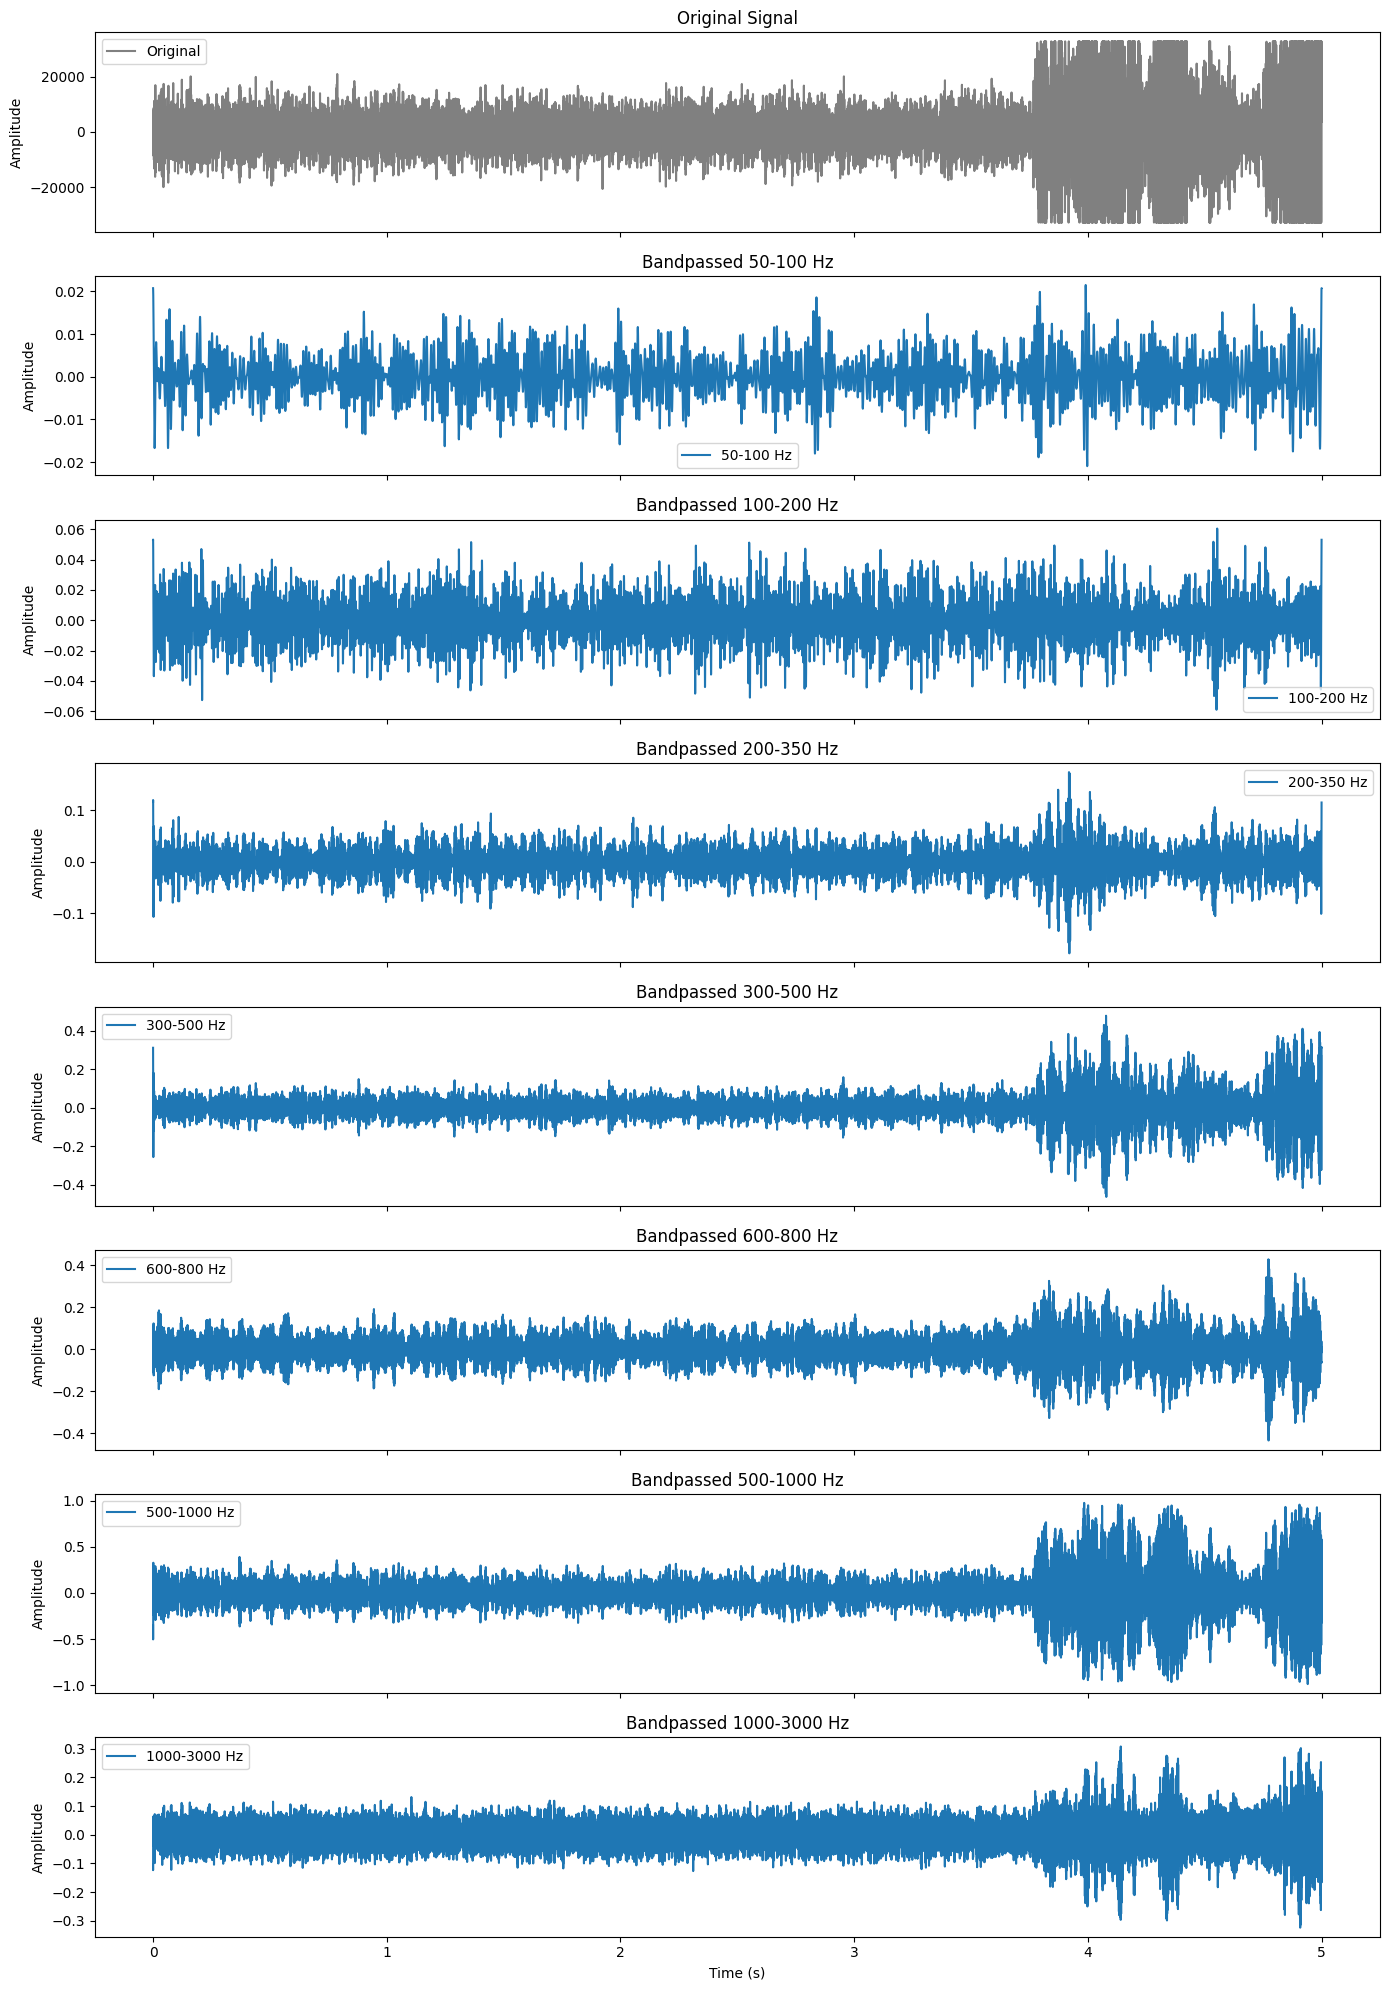

In [21]:
plot_bandpassed_time_series_subplots(
    "validate_data/2024-10-29/leak/ITRI0000003_rate_70_2023-09-14T152746.wav",
    freq_ranges=[(50, 100), (100, 200), (200, 350), (300, 500), (600, 800), (500, 1000), (1000, 3000)]
)


✅ 處理 segment: 0.00 → 1.00 秒, 長度：1.00 秒
✅ 處理 segment: 1.00 → 2.00 秒, 長度：1.00 秒
✅ 處理 segment: 2.00 → 3.00 秒, 長度：1.00 秒
✅ 處理 segment: 3.00 → 4.00 秒, 長度：1.00 秒
✅ 處理 segment: 4.00 → 5.00 秒, 長度：1.00 秒


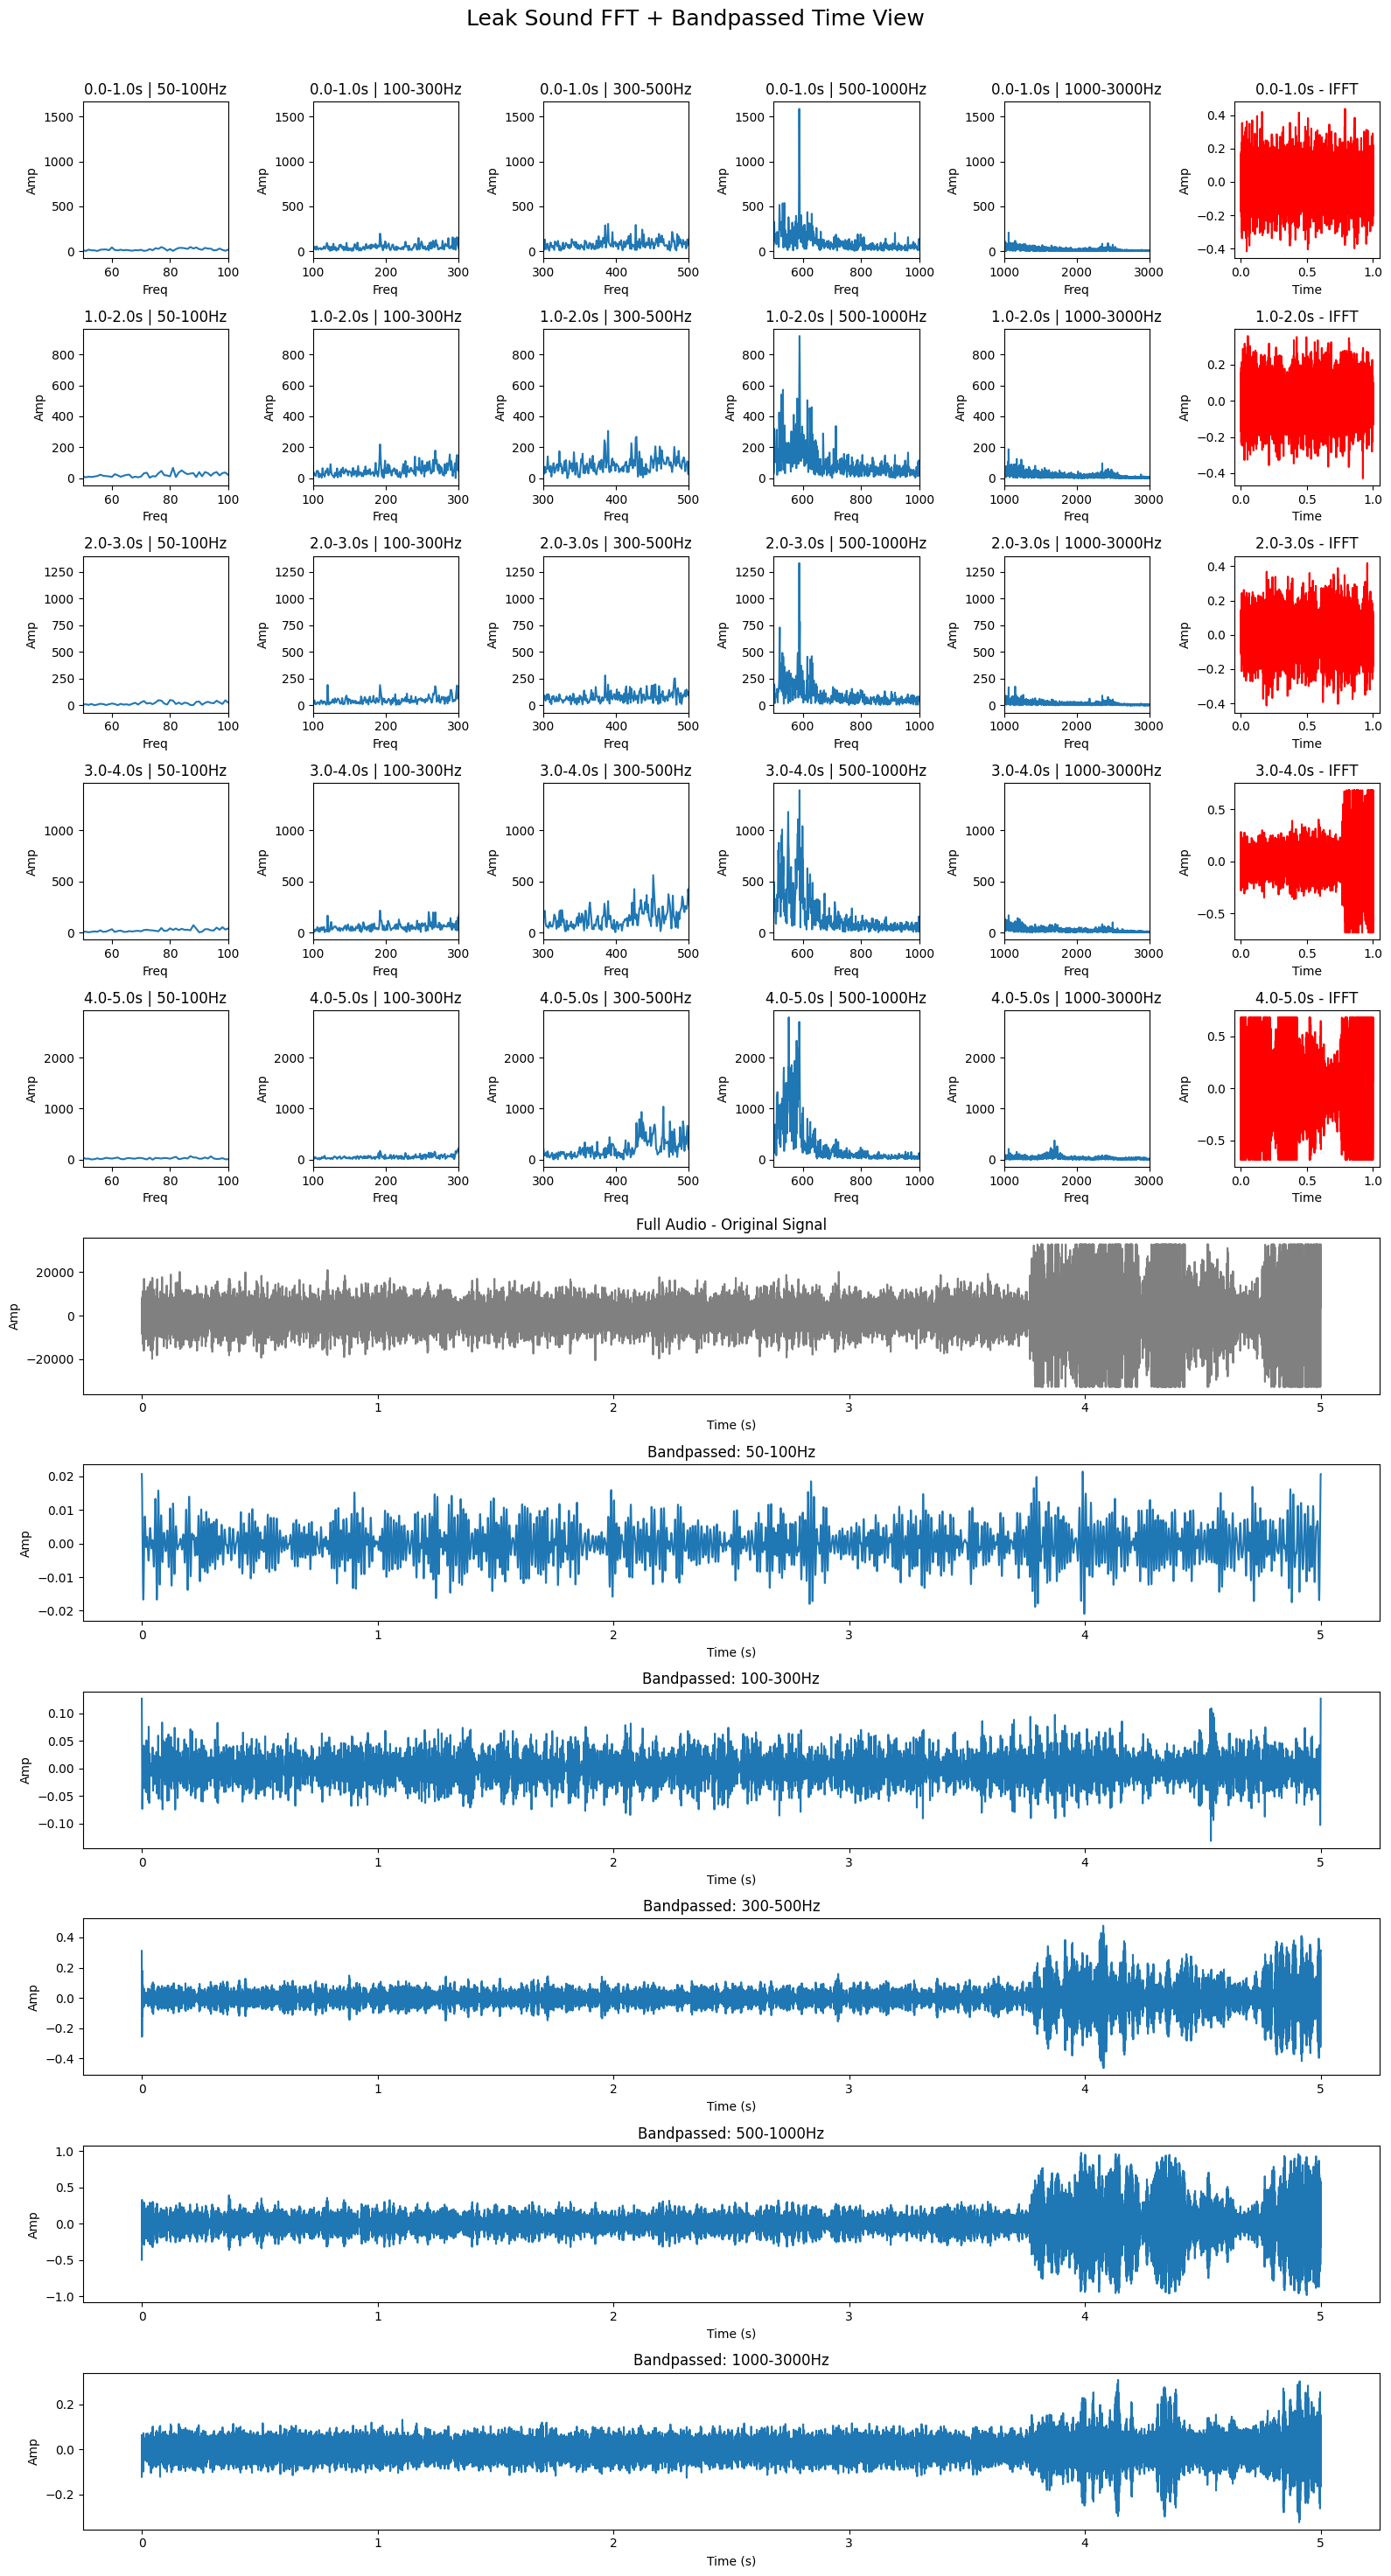

In [22]:
def plot_combined_fft_and_bandpass_views(path, segment_window=1.0, freq_ranges=None, title="Combined View"):
    if freq_ranges is None:
        freq_ranges = [(50, 100), (100, 300), (300, 500), (500, 1000), (1000, 3000)]

    # 📌 第一步：多段 FFT 分析
    segment_table = generate_segments_from_wav(path, window=segment_window)
    xf, yf, x, y = FFT_filter(path, segment_table, bandpass=None)

    n_segments = len(segment_table)
    n_freqs = len(freq_ranges)

    # 📌 第二步：整段 bandpass 還原
    sample_rate, sig, time = get_audio(path)
    N = len(sig)
    t = np.linspace(0, time, N)
    Yf = fft(sig) / sample_rate
    freqs = np.fft.fftfreq(N, d=1/sample_rate)

    bandpassed_signals = []
    for (low, high) in freq_ranges:
        mask = (np.abs(freqs) >= low) & (np.abs(freqs) <= high)
        Yf_masked = np.zeros_like(Yf, dtype=complex)
        Yf_masked[mask] = Yf[mask]
        y_filtered = ifft(Yf_masked).real
        bandpassed_signals.append((f"{low}-{high}Hz", y_filtered))

    # 📊 開始繪圖
    fig = plt.figure(figsize=(6 + 2 * n_freqs, 3 * n_segments + 2.5 * (len(freq_ranges) + 1)))
    plt.suptitle(title, fontsize=18, y=0.98)

    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(n_segments + len(freq_ranges) + 1, n_freqs + 1, figure=fig)

    # 🧩 頻譜 + 時域（多段）
    for i in range(n_segments):
        seg_start, seg_end = segment_table[i]
        for j, (f_start, f_end) in enumerate(freq_ranges):
            ax = fig.add_subplot(gs[i, j])
            ax.plot(xf[i], yf[i])
            ax.set_xlim(f_start, f_end)
            ax.set_title(f"{seg_start:.1f}-{seg_end:.1f}s | {f_start}-{f_end}Hz")
            ax.set_xlabel("Freq")
            ax.set_ylabel("Amp")

        # IFFT 還原時域
        ax = fig.add_subplot(gs[i, -1])
        ax.plot(x[i], y[i], color='red')
        ax.set_title(f"{seg_start:.1f}-{seg_end:.1f}s - IFFT")
        ax.set_xlabel("Time")
        ax.set_ylabel("Amp")

    # 🧩 整段原始與 bandpass 波形
    ax = fig.add_subplot(gs[n_segments, :])
    ax.plot(t, sig, color="gray")
    ax.set_title("Full Audio - Original Signal")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amp")

    for i, (label, yfilt) in enumerate(bandpassed_signals):
        ax = fig.add_subplot(gs[n_segments + i + 1, :])
        ax.plot(t, yfilt)
        ax.set_title(f"Bandpassed: {label}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amp")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
plot_combined_fft_and_bandpass_views(
    "validate_data/2024-10-29/leak/ITRI0000003_rate_70_2023-09-14T152746.wav",
    segment_window=1.0,
    freq_ranges=[(50, 100), (100, 300), (300, 500), (500, 1000), (1000, 3000)],
    title="Leak Sound FFT + Bandpassed Time View"
)


Sample rate: 48000
🎧 STFT PCA - Explained Variance Ratio:
  PC1: 8.78%
  PC2: 3.12%
  PC3: 3.03%

🎧 Mel PCA - Explained Variance Ratio:
  PC1: 56.01%
  PC2: 8.77%
  PC3: 7.57%


C:\Users\User\AppData\Local\Temp\ipykernel_41348\2430091920.py:36: FutureWarning: Pass y=[ 0.00872803  0.00772095  0.0078125  ... -0.01095581 -0.01000977
 -0.00942993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S_mel = librosa.feature.melspectrogram(y_segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)


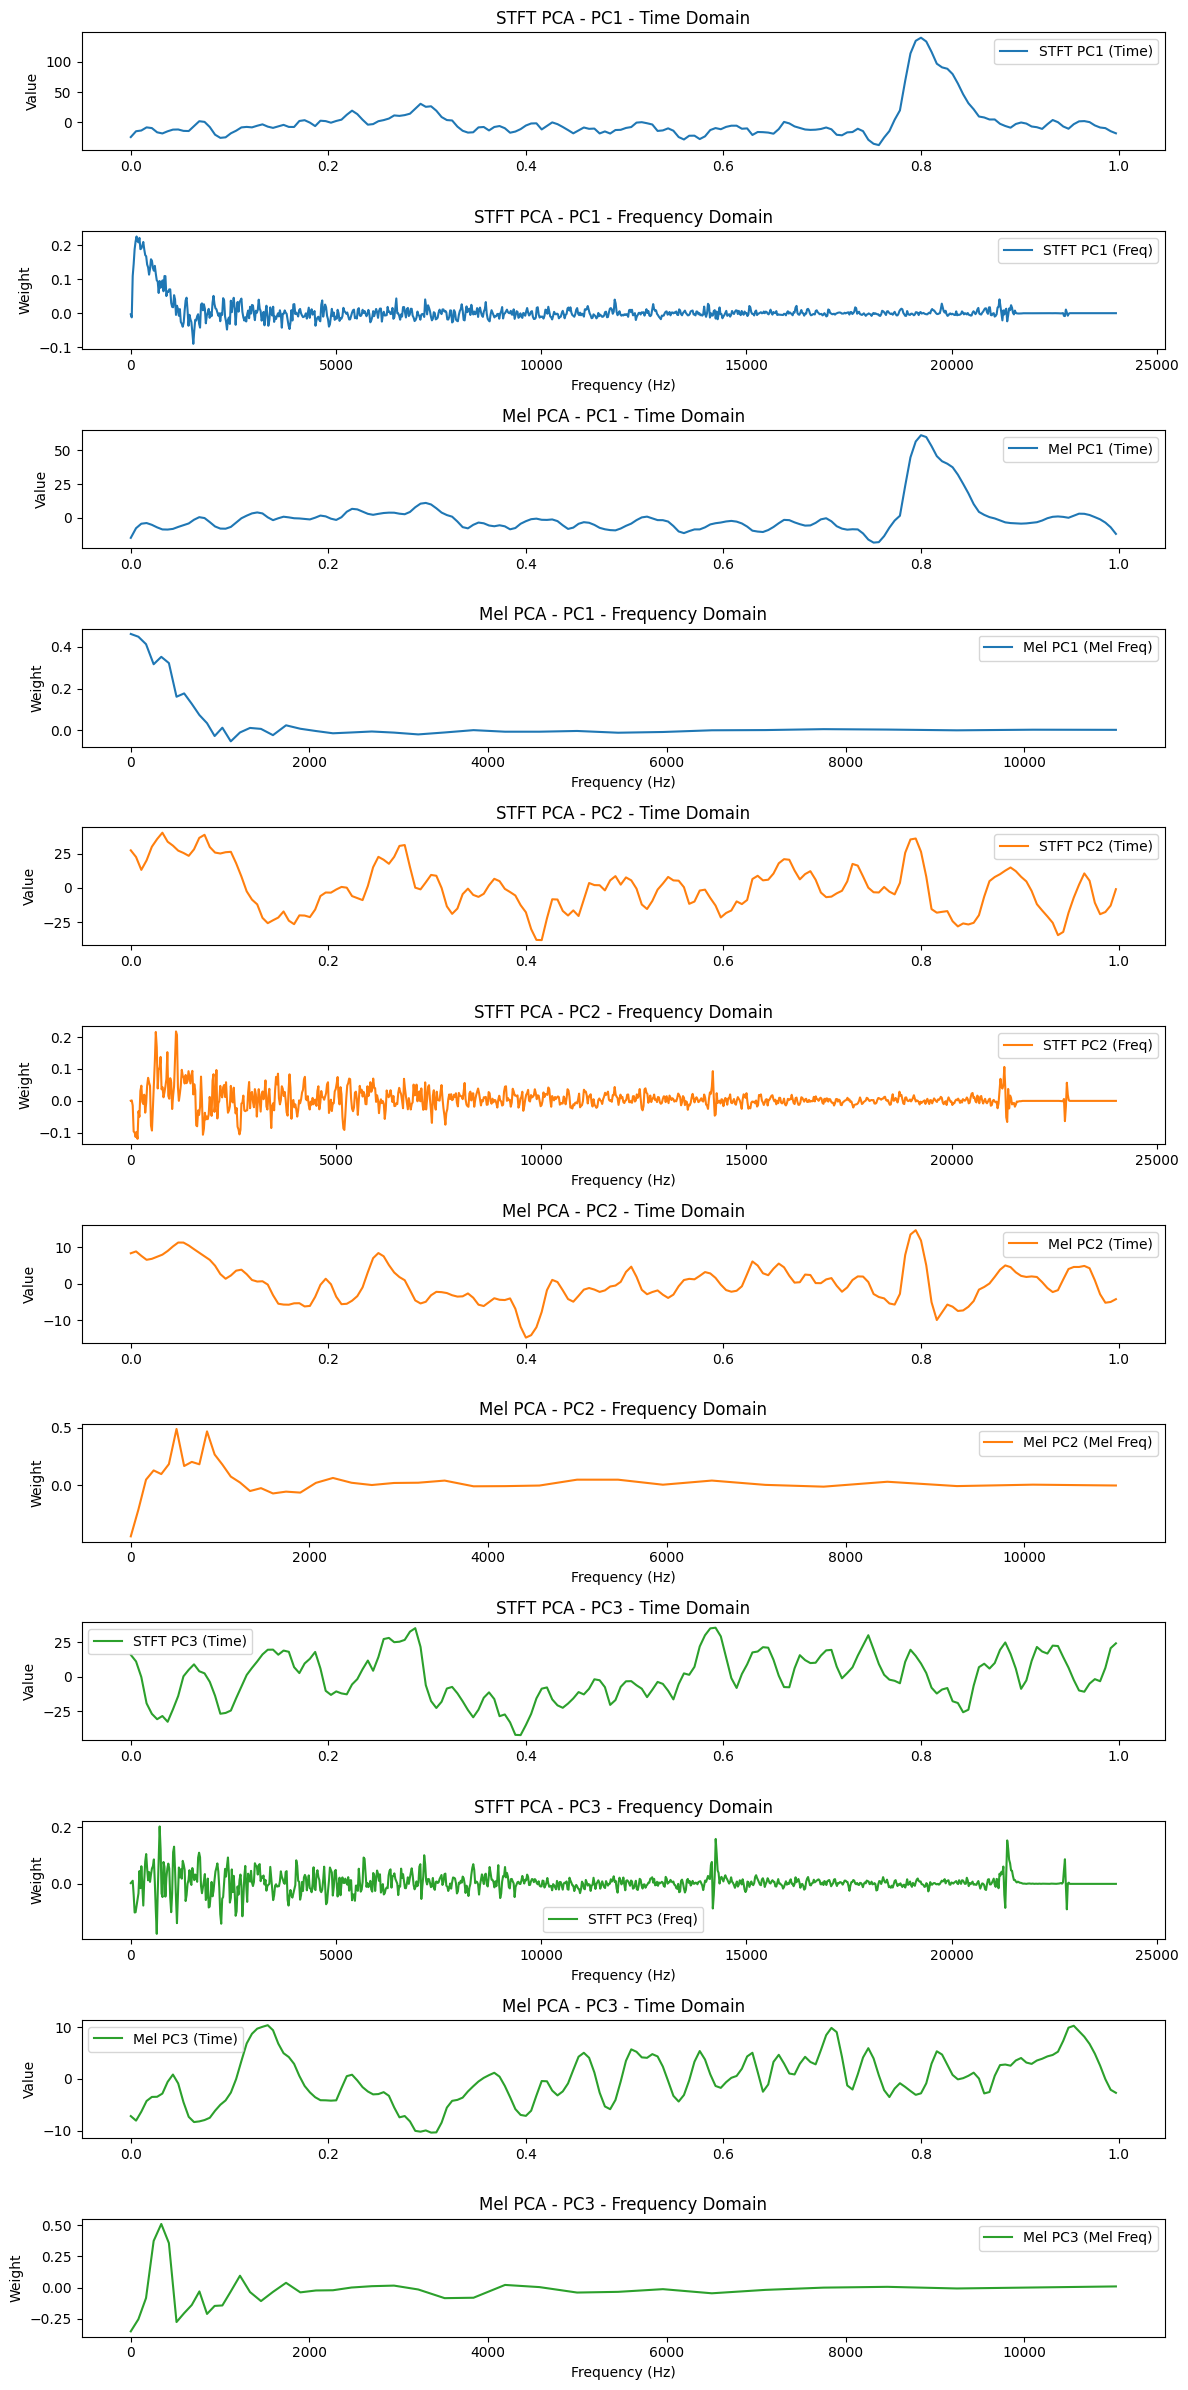

In [20]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 載入音訊
audio_path = "dataset/2025-04-30/90/ITRI0000007/2025-04-30T144452.wav"
y, sr = librosa.load(audio_path, sr=None)
print("Sample rate:", sr)

# 取前 1 秒資料
duration = 1  # 秒
sample_count = int(sr * duration)
y_segment = y[:sample_count]

# === STFT ===
n_fft = 2048
hop_length = 256
S = np.abs(librosa.stft(y_segment, n_fft=n_fft, hop_length=hop_length))
S_db = librosa.amplitude_to_db(S, ref=np.max)
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# === STFT PCA ===
n_components = 3
S_T = S_db.T  # (時間, 頻率)
pca_stft = PCA(n_components=n_components)
S_pca_stft = pca_stft.fit_transform(S_T)
time_axis = np.arange(S_pca_stft.shape[0]) * hop_length / sr

print("🎧 STFT PCA - Explained Variance Ratio:")
for i, ratio in enumerate(pca_stft.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.2%}")

# === Mel Spectrogram ===
n_mels = 40
S_mel = librosa.feature.melspectrogram(y_segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
mel_freqs = librosa.mel_frequencies(n_mels=n_mels)

# === Mel PCA ===
S_mel_T = S_mel_db.T
pca_mel = PCA(n_components=n_components)
S_pca_mel = pca_mel.fit_transform(S_mel_T)

print("\n🎧 Mel PCA - Explained Variance Ratio:")
for i, ratio in enumerate(pca_mel.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.2%}")

# === 畫圖：共 2 組，每組 2 x n_components 行 ===
fig, axes = plt.subplots(n_components * 4, 1, figsize=(12, 4 * n_components * 2), sharex=False)
colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(n_components):
    # STFT - 時間域
    axes[4 * i].plot(time_axis, S_pca_stft[:, i], color=colors[i], label=f'STFT PC{i+1} (Time)')
    axes[4 * i].set_ylabel("Value")
    axes[4 * i].set_title(f'STFT PCA - PC{i+1} - Time Domain')
    axes[4 * i].legend()

    # STFT - 頻率域
    axes[4 * i + 1].plot(freqs, pca_stft.components_[i], color=colors[i], label=f'STFT PC{i+1} (Freq)')
    axes[4 * i + 1].set_xlabel("Frequency (Hz)")
    axes[4 * i + 1].set_ylabel("Weight")
    axes[4 * i + 1].set_title(f'STFT PCA - PC{i+1} - Frequency Domain')
    axes[4 * i + 1].legend()

    # Mel - 時間域
    axes[4 * i + 2].plot(time_axis, S_pca_mel[:, i], color=colors[i], label=f'Mel PC{i+1} (Time)')
    axes[4 * i + 2].set_ylabel("Value")
    axes[4 * i + 2].set_title(f'Mel PCA - PC{i+1} - Time Domain')
    axes[4 * i + 2].legend()

    # Mel - 頻率域
    axes[4 * i + 3].plot(mel_freqs, pca_mel.components_[i], color=colors[i], label=f'Mel PC{i+1} (Mel Freq)')
    axes[4 * i + 3].set_xlabel("Frequency (Hz)")
    axes[4 * i + 3].set_ylabel("Weight")
    axes[4 * i + 3].set_title(f'Mel PCA - PC{i+1} - Frequency Domain')
    axes[4 * i + 3].legend()

plt.tight_layout()
plt.show()
